In [ ]:
## Testing relation extraction

In [1]:
from dataset_creator import *
from transformers import AutoModelForTokenClassification
import matplotlib.pyplot as plt
model = AutoModelForTokenClassification.from_pretrained("trained_models/august_23/ts_finetuned/")
tokenizer = AutoTokenizer.from_pretrained("trained_models/august_23/tokenizer_added_tokens/")

/home/a8hik/anaconda3/envs/py3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def load_images(root_dir='dekra_annotations/images/template_2_dekra', over_write=True):
    temp_image_dir = 'temp_images'
    
    if over_write and os.path.exists(temp_image_dir):
        shutil.rmtree(temp_image_dir)
        
    if not os.path.exists(temp_image_dir):
        os.mkdir(temp_image_dir)
    
    
    for i, sub_dir in enumerate(os.listdir(root_dir)):
        image_path = f'{root_dir}/{sub_dir}/page_0.jpg'
        image_name = f'{temp_image_dir}/image_{i}.jpg'
        image = np.array(Image.open(image_path))
        cv2.imwrite(image_name, image)

In [ ]:
load_images()

In [3]:
tokens, bboxes, image = get_ocr_data(image_path='temp_images/image_4.jpg')
tokens, bboxes = preprocess_tokens(tokens=tokens, bboxes=bboxes)
image = np.array(image)

n_boxes 425


In [4]:
print(len(bboxes))
print(len(tokens))

250
250


In [ ]:
'''def unnormalize_box(bbox, width, height):
     #x1,y1,x2,y2 = yolobbox2bbox(bbox[0], bbox[1], bbox[2], bbox[3])
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

#strip out non-ASCII text so we can draw the text on the image
# using OpenCV, then draw a bounding box around the text along
# # with the text itself

for i in range(len(bboxes)):
    text = tokens[i]
    bbox = bboxes[i]
     
    bbox = unnormalize_box(bbox, image.shape[1], image.shape[0])
    bbox = np.array(bbox, dtype=np.int32)
    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
    
    cv2.rectangle(image, (x1, y1), (x2, y2 ), (0, 255, 0), 2)
    cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 0, 255), 3)'''

In [5]:
import pytesseract
from transformers import LayoutLMv2FeatureExtractor

feature_extractor = LayoutLMv2FeatureExtractor(ocr_lang="deu")
tokenizer, model = add_tokens_tokenizer(tokens = tokens, tokenizer = tokenizer, model = model)
#print(f'tokenized result {tokenizer.tokenize("ergebnis")}')
input_ids, bboxes, input_id_map = encode_tokens(tokens=tokens, bboxes=bboxes, tokenizer=tokenizer)
inputs = feature_extractor(image, return_tensors="pt")
print(inputs.keys())

dict_keys(['pixel_values', 'words', 'boxes'])


In [6]:
encoding = tokenizer(inputs.words, boxes=inputs.boxes, return_offsets_mapping=False,
                     padding="max_length", max_length=512, truncation=True, return_tensors="pt")

In [7]:

for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 512])
attention_mask torch.Size([1, 512])
bbox torch.Size([1, 512, 4])


In [8]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

with torch.no_grad():
  outputs = model(input_ids=encoding.input_ids.to(device),
                  attention_mask=encoding.attention_mask.to(device),
                  bbox=encoding.bbox.to(device),
                  image=inputs.pixel_values.to(device),
  )

In [9]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

image = Image.fromarray(image)
width, height = image.size

In [10]:
import numpy as np

#is_subword = np.array(encoding.offset_mapping.squeeze().tolist())[:,0] != 0

#true_predictions = [model.config.id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
#true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

true_predictions = [model.config.id2label[pred] for idx, pred in enumerate(predictions)]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

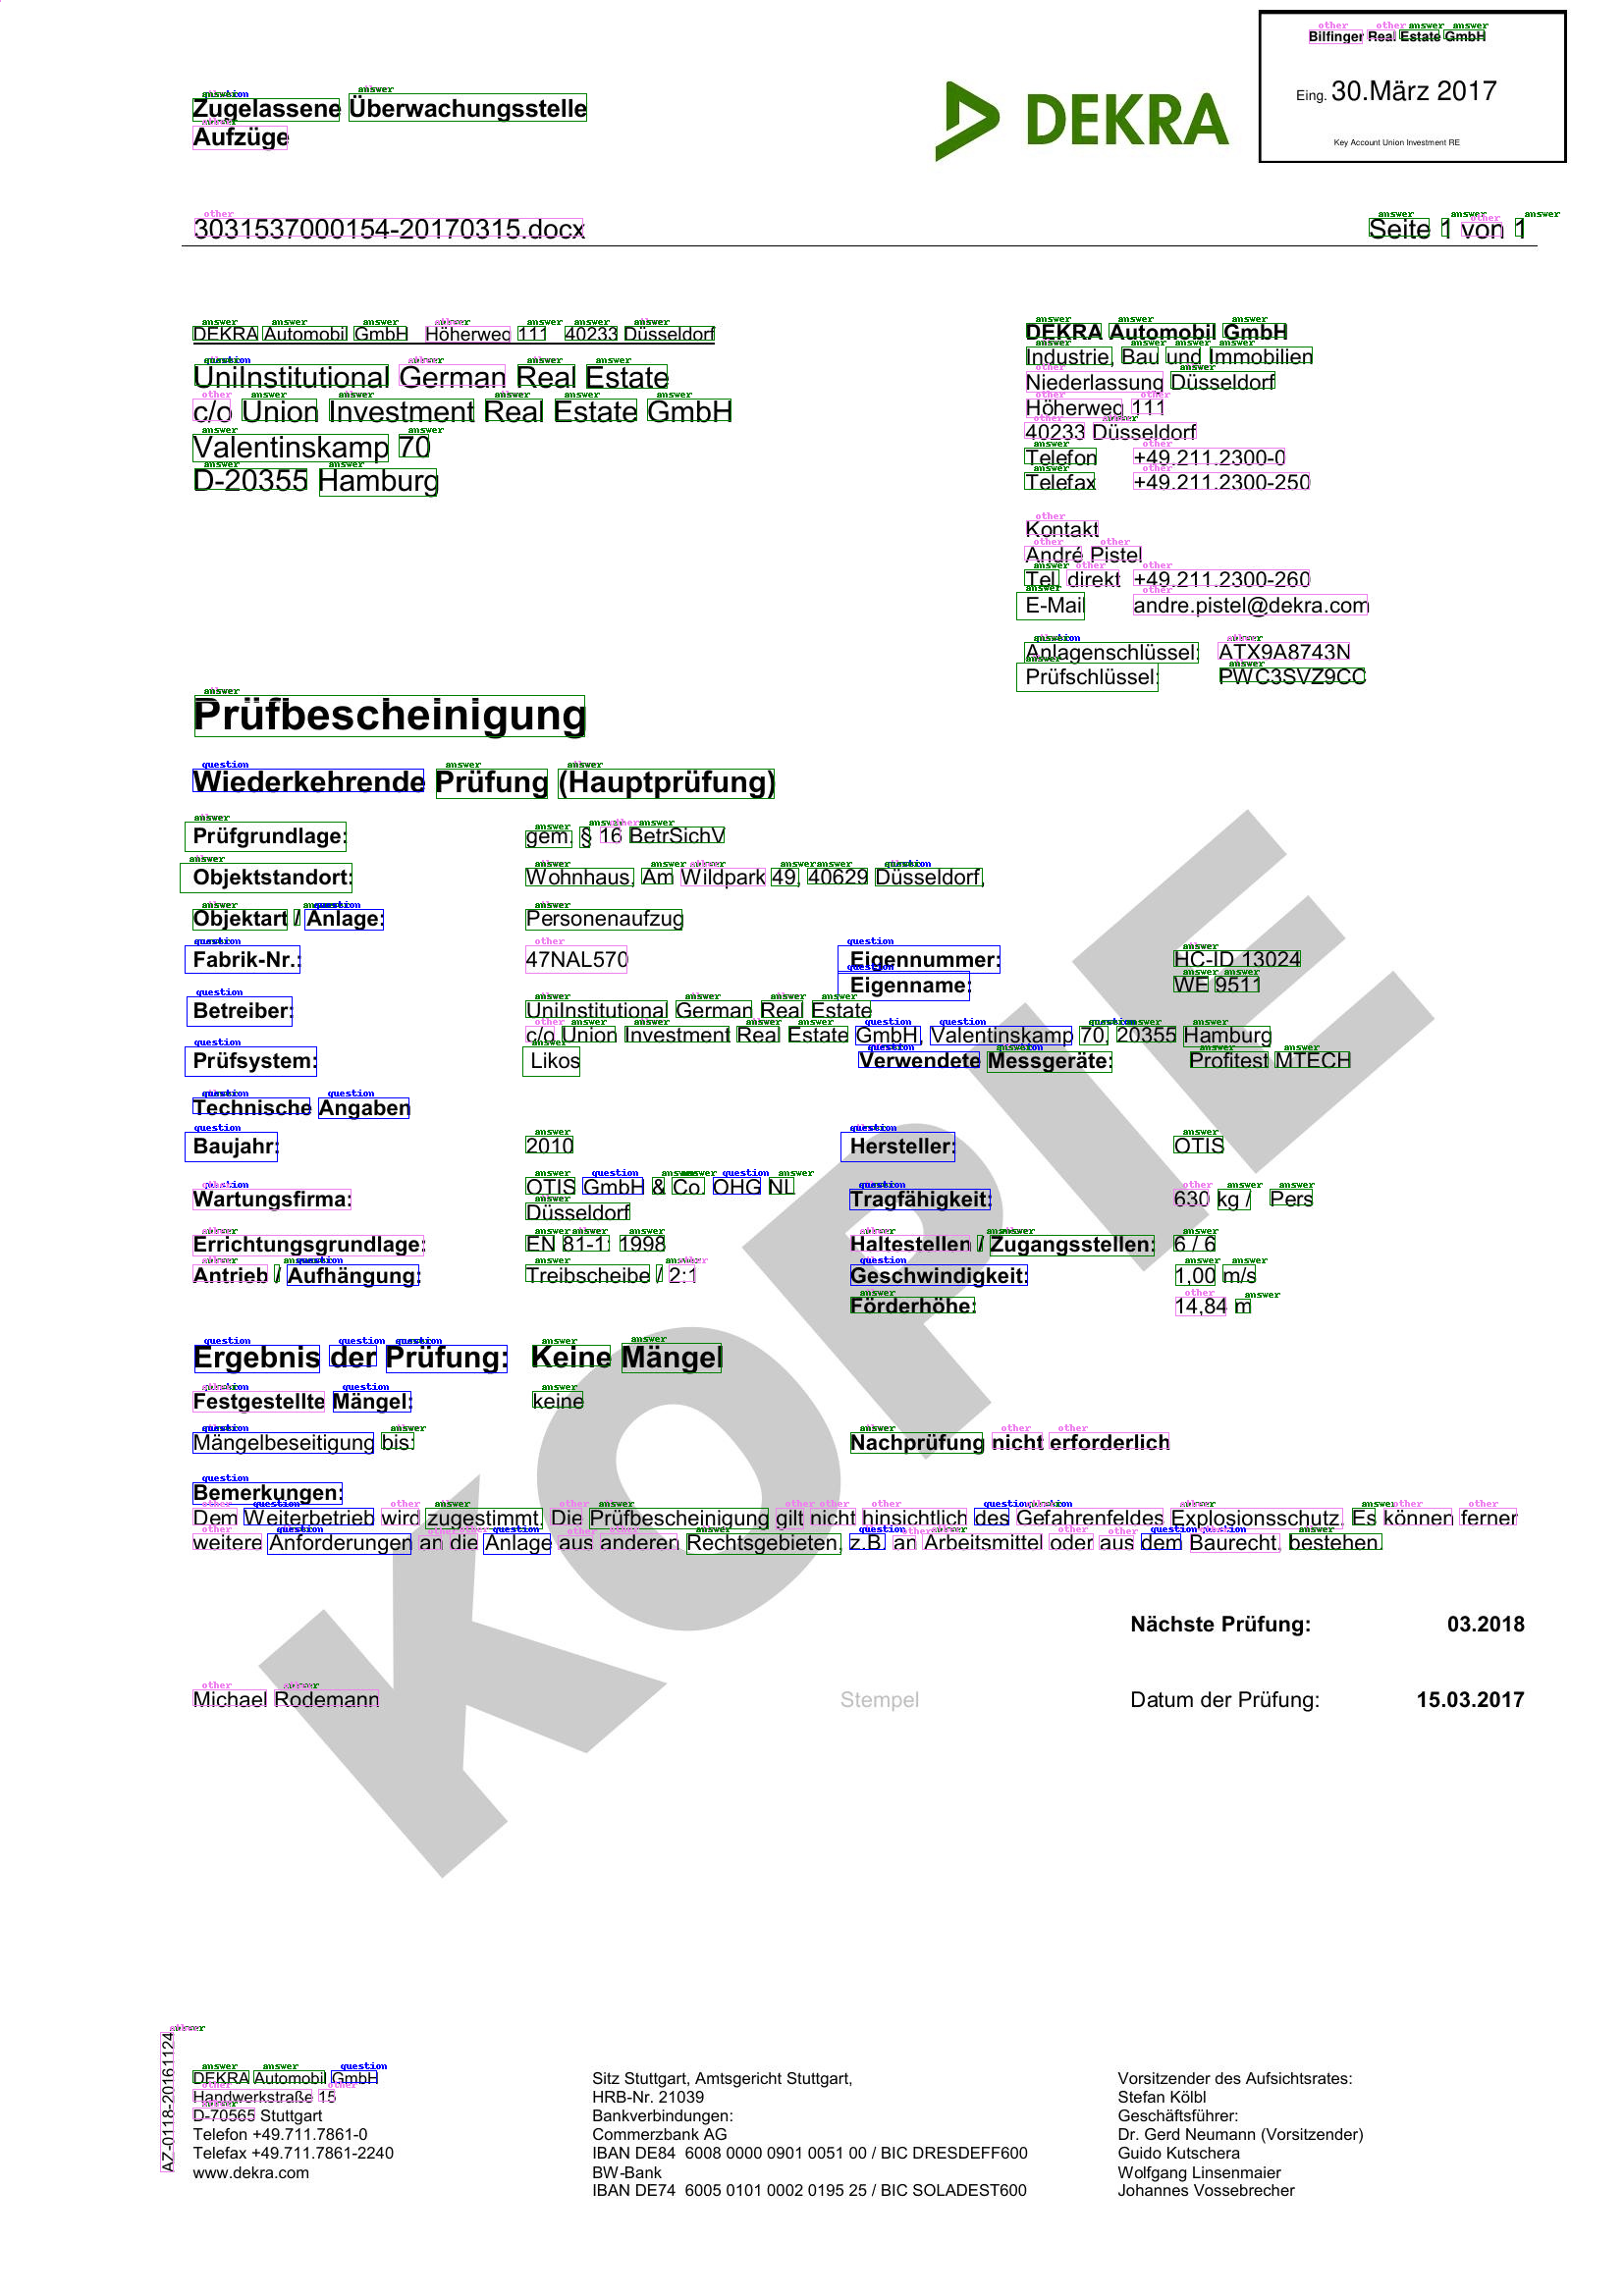

In [11]:

from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [ ]:


#input_ids, bboxes, _ = encode_tokens(tokens=tokens, bboxes=bboxes, tokenizer=tokenizer)

In [12]:
print(input_ids)

[317806, 317830, 1690, 262133, 96, 97761, 250306, 250038, 250100, 250013, 317807, 250125, 28, 542, 317804, 317844, 250306, 95845, 38267, 165, 317831, 317836, 317855, 317833, 36682, 306831, 317855, 317804, 317844, 250306, 317833, 36682, 306831, 317855, 317841, 270078, 1690, 262133, 96, 97761, 317842, 69941, 317856, 1690, 262133, 96, 97761, 250306, 317805, 2358, 2924, 317848, 317823, 258043, 250128, 317837, 3477, 285659, 28, 317874, 8131, 7307, 317871, 250123, 317818, 250124, 317864, 317817, 317809, 250096, 250053, 159601, 250108, 250030, 30203, 611, 250036, 250080, 317810, 444, 317872, 7218, 317873, 317855, 250024, 109224, 317816, 250044, 317860, 250131, 317839, 250033, 642, 317867, 317845, 317841, 270078, 1690, 262133, 96, 97761, 317842, 69941, 317856, 1690, 262133, 96, 97761, 250306, 317805, 2358, 317854, 258043, 317813, 317868, 250104, 250116, 250084, 250161, 250022, 250139, 250117, 1532, 250107, 317851, 250062, 250012, 250101, 250023, 317851, 250306, 552, 250137, 13169, 317855, 22, 

In [13]:
class testDataset(Dataset):
    def __init__(self, image, input_ids, bbox, tokens):
        self.image = image
        self.input_ids = input_ids
        self.bbox = bbox
        self.tokens = tokens
        
    
    def generate_id(self, idx:int = None):
        return f'sample_{idx}'
    
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        
          
        id = self.generate_id(idx)
        features  = {'id': id, 'input_ids': self.input_ids, 'bbox':self.bbox, 'labels':[1], 'original_image': self.image, 'image':[1], 'entities':[1], 'relations':[1]}
        '''Dataset = {
            "features" : {'id': id, 'input_ids': input_ids, 'labels':labels, 'original_image': image, 'image':image_resized, 'entities':entities, 'relations':relations},
            "num_rows" : self.__len__()    
        }'''
        return features

In [14]:
@dataclass
class DataCollatorForTokenClassificationModified:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):
        # prepare image input
        image = self.feature_extractor([feature["original_image"] for feature in features], return_tensors="pt").pixel_values

        # prepare text input
        for feature in features:
            del feature["image"]
            del feature["id"]
            del feature["original_image"]
            del feature["entities"]
            del feature["relations"]
            del feature["labels"] ## This is added for debugging relation extraction. But this line must be removed if training for token classification

        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )

        batch["image"] = image

        return batch
    
@dataclass
class DataCollatorForTokenClassificationVisualDebug:
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.

    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.file_utils.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (:obj:`int`, `optional`, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
    """

    feature_extractor: LayoutLMv2FeatureExtractor
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100

    def __call__(self, features):
        # prepare image input
        image = self.feature_extractor([feature["original_image"] for feature in features], return_tensors="pt").pixel_values

        # prepare text input
        for feature in features:
            del feature["image"]
            del feature["id"]
            #del feature["original_image"]
            del feature["entities"]
            del feature["relations"]
            del feature["labels"] ## This is added for debugging relation extraction. But this line must be removed if training for token classification

        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt"
        )

        batch["image"] = image

        return batch

In [15]:
image_np = np.asarray(image)
test_dataset = testDataset(image_np, input_ids, bboxes, tokens)


In [16]:
from transformers import LayoutLMv2FeatureExtractor
#tokenizer = AutoTokenizer.from_pretrained("trained_models/July_01/tokenizer_added_tokens/")

feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=True)
data_collator_tc = DataCollatorForTokenClassificationModified(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=None,
    padding="max_length",
    max_length=512,
)
data_collator = DataCollatorForKeyValueExtraction(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=8,
    padding="max_length",
    max_length=512,
)

data_collator_visual = DataCollatorForTokenClassificationVisualDebug(
    feature_extractor,
    tokenizer,
    pad_to_multiple_of=8,
    padding="max_length",
    max_length=512,
)


In [17]:
from transformers import AutoModelForTokenClassification
#os.path.exists("trained_models/July_01/token_classification_custom")
#model = AutoModelForTokenClassification.from_pretrained("trained_models/July_01/token_classification_custom")
model = AutoModelForTokenClassification.from_pretrained("trained_models/august_23/ts_finetuned/")
test_dataset_custom_tc = test_dataset
dataloader_tc = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator_tc)

dataloader_tc_visual = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator_visual)
dataloader = DataLoader(test_dataset, batch_size=1, collate_fn=data_collator)
tc_iter = iter(dataloader_tc)
visual_iter = iter(dataloader_tc_visual)
test_iter = iter(dataloader)

You're using a LayoutXLMTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/a8hik/anaconda3/envs/py3_10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:716: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  tensor = as_tensor(value)


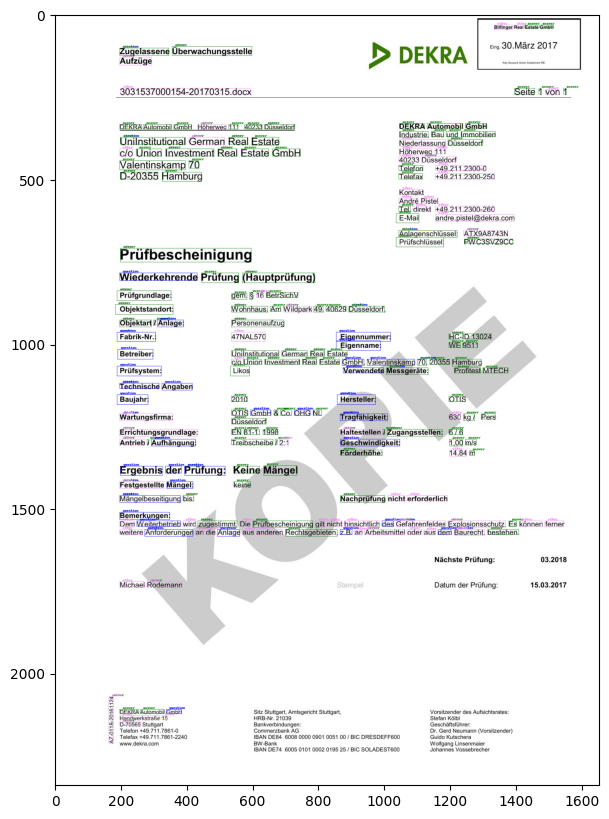

In [18]:
test_batch_tc = next(tc_iter)
test_batch_visual = next(visual_iter)
test_batch = next(test_iter)

device = "cuda" if torch.cuda.is_available() else "cpu"
test_image_1 = Image.fromarray(test_batch_visual['original_image'].cpu().detach().numpy()[0])

plt.figure(figsize=(15,10))
plt.imshow(test_image_1)

## Relation Extraction

In [20]:

import numpy as np

# take argmax on last dimension to get predicted class ID per token
predictions = outputs.logits.argmax(-1).squeeze().tolist()
print(predictions)
# we're only interested in tokens which aren't subwords
# we'll use the offset mapping for that
#is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

id2label = {"HEADER":0, "QUESTION":1, "ANSWER":2}

# finally, store recognized "question" and "answer" entities in a list
entities = []
current_entity = None
start = None
end = None
entity_local = []
#for idx, (id, pred) in enumerate(zip(inputs.input_ids[0].tolist(), predictions)):
for idx, (id, pred) in enumerate(zip(test_batch_tc['input_ids'][0].tolist(), predictions)):
  #if not is_subword[idx]:
  print(id)
  predicted_label = model.config.id2label[pred]
  if predicted_label.startswith("B"):
    if len(entity_local)==0:
      entity_local.append(idx)
      current_entity = predicted_label.replace("B-", "")
    else:
      entity_local.append(idx)
      start = entity_local[0]
      end = entity_local[-1]
      entities.append((start, end, current_entity, id2label[current_entity]))
      entity_local = []
      entity_local.append(idx)
      #current_entity = None

  if predicted_label.startswith("I"):
    current_entity = predicted_label.replace("I-", "")
    entity_local.append(idx)
  print(tokenizer.decode([id]), predicted_label)

[0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 4, 4, 4, 0, 2, 4, 4, 4, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 4, 4, 4, 2, 0, 0, 4, 4, 2, 0, 2, 4, 2, 0, 2, 5, 2, 2, 0, 0, 4, 0, 4, 4, 0, 2, 2, 0, 2, 0, 2, 2, 4, 0, 4, 4, 4, 2, 2, 2, 2, 2, 0, 0, 2, 2, 4, 4, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 4, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 5, 5, 5, 4, 2, 2, 2, 0, 2, 4, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 4, 4, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 4, 2, 4, 2, 0, 2, 5, 2, 2, 0, 2, 0, 2, 2, 2, 5, 2, 2, 0, 4, 1, 5, 2, 5, 5, 5, 0, 0, 0, 1, 5, 5, 2, 2, 2, 2, 0, 2, 1, 1, 5, 2, 4, 1, 5, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 4, 4, 0, 2, 2, 0, 2, 0, 2, 2, 4, 0, 4, 4, 5, 5, 5, 5, 5, 5, 2, 4, 4, 5, 1, 5, 2, 4, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 4, 1, 0, 2, 1, 1, 1, 1, 5, 2, 2, 0, 1, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 1, 5, 5, 2, 4, 5, 

In [ ]:
entities

In [21]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

#inputs = inputs.to('cpu')

inputs = test_batch_tc
#inputs = inputs.pop('labels')
model.to('cpu')
inputs = inputs.to('cpu')
inputs.keys()

dict_keys(['input_ids', 'bbox', 'attention_mask', 'image'])

In [22]:
print(inputs['image'])

tensor([[[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[254, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],

         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]]], dtype=torch.uint8)


In [23]:


from transformers import LayoutLMv2ForRelationExtraction

# step 2: run LayoutLMv2ForRelationExtraction /content/drive/MyDrive/relation_extraction
#relation_extraction_model = LayoutLMv2ForRelationExtraction.from_pretrained("nielsr/layoutxlm-finetuned-xfund-fr-re")

relation_extraction_model = LayoutLMv2ForRelationExtraction.from_pretrained("trained_models/august_23/re_finetuned/")
relation_extraction_model.to('cpu')

entity_dict = {'start': [entity[0] for entity in entities],
        'end': [entity[1] for entity in entities],
        'label': [entity[3] for entity in entities]}



with torch.no_grad():
  outputs = relation_extraction_model(**inputs,
                                      entities=[entity_dict],
                                      relations=[{'start_index': [], 'end_index': [], 'head': [], 'tail': []}])

IndexError: index out of range in self